In [ ]:
 Install the Kaggle library
!pip install -q kaggle

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 73% 44.0M/60.3M [00:00<00:00, 236MB/s]
100% 60.3M/60.3M [00:00<00:00, 245MB/s]


In [ ]:
# Unzip the downloaded file
!unzip fer2013.zip -d fer2013

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/sad/Training_65242339.jpg  
  inflating: fer2013/train/sad/Training_65267116.jpg  
  inflating: fer2013/train/sad/Training_65275626.jpg  
  inflating: fer2013/train/sad/Training_6529266.jpg  
  inflating: fer2013/train/sad/Training_65329617.jpg  
  inflating: fer2013/train/sad/Training_65338712.jpg  
  inflating: fer2013/train/sad/Training_65338797.jpg  
  inflating: fer2013/train/sad/Training_65387162.jpg  
  inflating: fer2013/train/sad/Training_65404494.jpg  
  inflating: fer2013/train/sad/Training_65426218.jpg  
  inflating: fer2013/train/sad/Training_65430136.jpg  
  inflating: fer2013/train/sad/Training_65437377.jpg  
  inflating: fer2013/train/sad/Training_6545735.jpg  
  inflating: fer2013/train/sad/Training_65463385.jpg  
  inflating: fer2013/train/sad/Training_65473985.jpg  
  inflating: fer2013/train/sad/Training_65502829.jpg  
  inflating: fer2013/train/sad/Training_65505359.jpg  
  inflating: fer

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import glob
import random
import cv2
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
# define some helper functions
def get_all_image_paths(root_dir, extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []
    for extension in extensions:
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', f'*{extension}'), recursive=True))
    return image_paths

def extract_emotion_from_filename(image_path: str) -> str:
    # /kaggle/input/fer2013/train/angry/Training_10118481.jpg
    return image_path.split('/')[-2]

# test functions work properly
print(extract_emotion_from_filename('/kaggle/input/fer2013/train/angry/Training_10118481.jpg'))
image_paths = get_all_image_paths('/kaggle/input/fer2013/train')

angry


In [ ]:
class FacialExpressionVanillaDataset(Dataset):

    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.image_paths = get_all_image_paths(root_dir)
        # i dont need disgust to be classified (for my AI gf)
        # and probably surprise (but i i'll think about it later)

        # Assuming `self.image_paths` is a list of image paths
        self.image_paths = list(filter(lambda path: not any(class_name in path for class_name in ['disgust', 'fear', 'surprise']), self.image_paths))


        random.shuffle(self.image_paths)
        self.image_labels = [extract_emotion_from_filename(path) for path in self.image_paths]

        # transform emotion labels to numerical
        self.label_encoder = LabelEncoder()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.image_labels = torch.from_numpy(self.label_encoder.fit_transform(self.image_labels)).to(self.device)

        self.transform = transform # random transformation of image to "extend" dataset using albumentation module

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        #image = read_image(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image'].to(self.device)

        return image, label

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    # Resize and convert to grayscale
    A.Resize(224, 224),
    A.ToGray(p=1.0),

    # Data Augmentation
    A.HorizontalFlip(p=0.5),           # Random horizontal flip
    A.VerticalFlip(p=0.5),             # Random vertical flip
    A.Rotate(limit=45, p=0.5),         # Random rotation within a limit
    A.RandomBrightnessContrast(p=0.5), # Adjust brightness and contrast randomly
    A.GaussianBlur(blur_limit=5, sigma_limit=(0.1, 2.0), p=0.5), # Optional: Keep this blur or modify

    # Normalization and conversion
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.ToGray(p=1.0),
    A.GaussianBlur(blur_limit=5, sigma_limit=(0.1, 2.0)),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

train_dataset = FacialExpressionVanillaDataset('/content/fer2013/train', transform=transform)
test_dataset = FacialExpressionVanillaDataset('/content/fer2013/test', transform=transform)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torch.utils.data import random_split, DataLoader

# Set the split ratio (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 32  # Define batch size

# Create DataLoader for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f"train dataset size: {len(train_dataset)}")
print(f"test dataset size: {len(test_dataset)}")

train dataset size: 21005
test dataset size: 5212


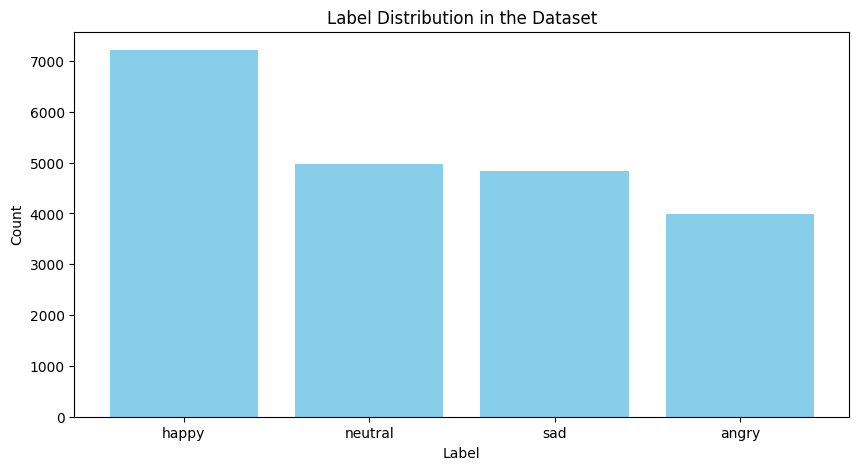

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Count label occurrences in the dataset
def plot_label_distribution(dataset, label_encoder):
    label_counts = Counter(dataset.image_labels.cpu().numpy())
    label_names = label_encoder.inverse_transform(list(label_counts.keys()))
    label_values = list(label_counts.values())

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    plt.bar(label_names, label_values, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Label Distribution in the Dataset')
    plt.show()

# Plot the label distribution for train_dataset
plot_label_distribution(train_dataset, train_dataset.label_encoder)


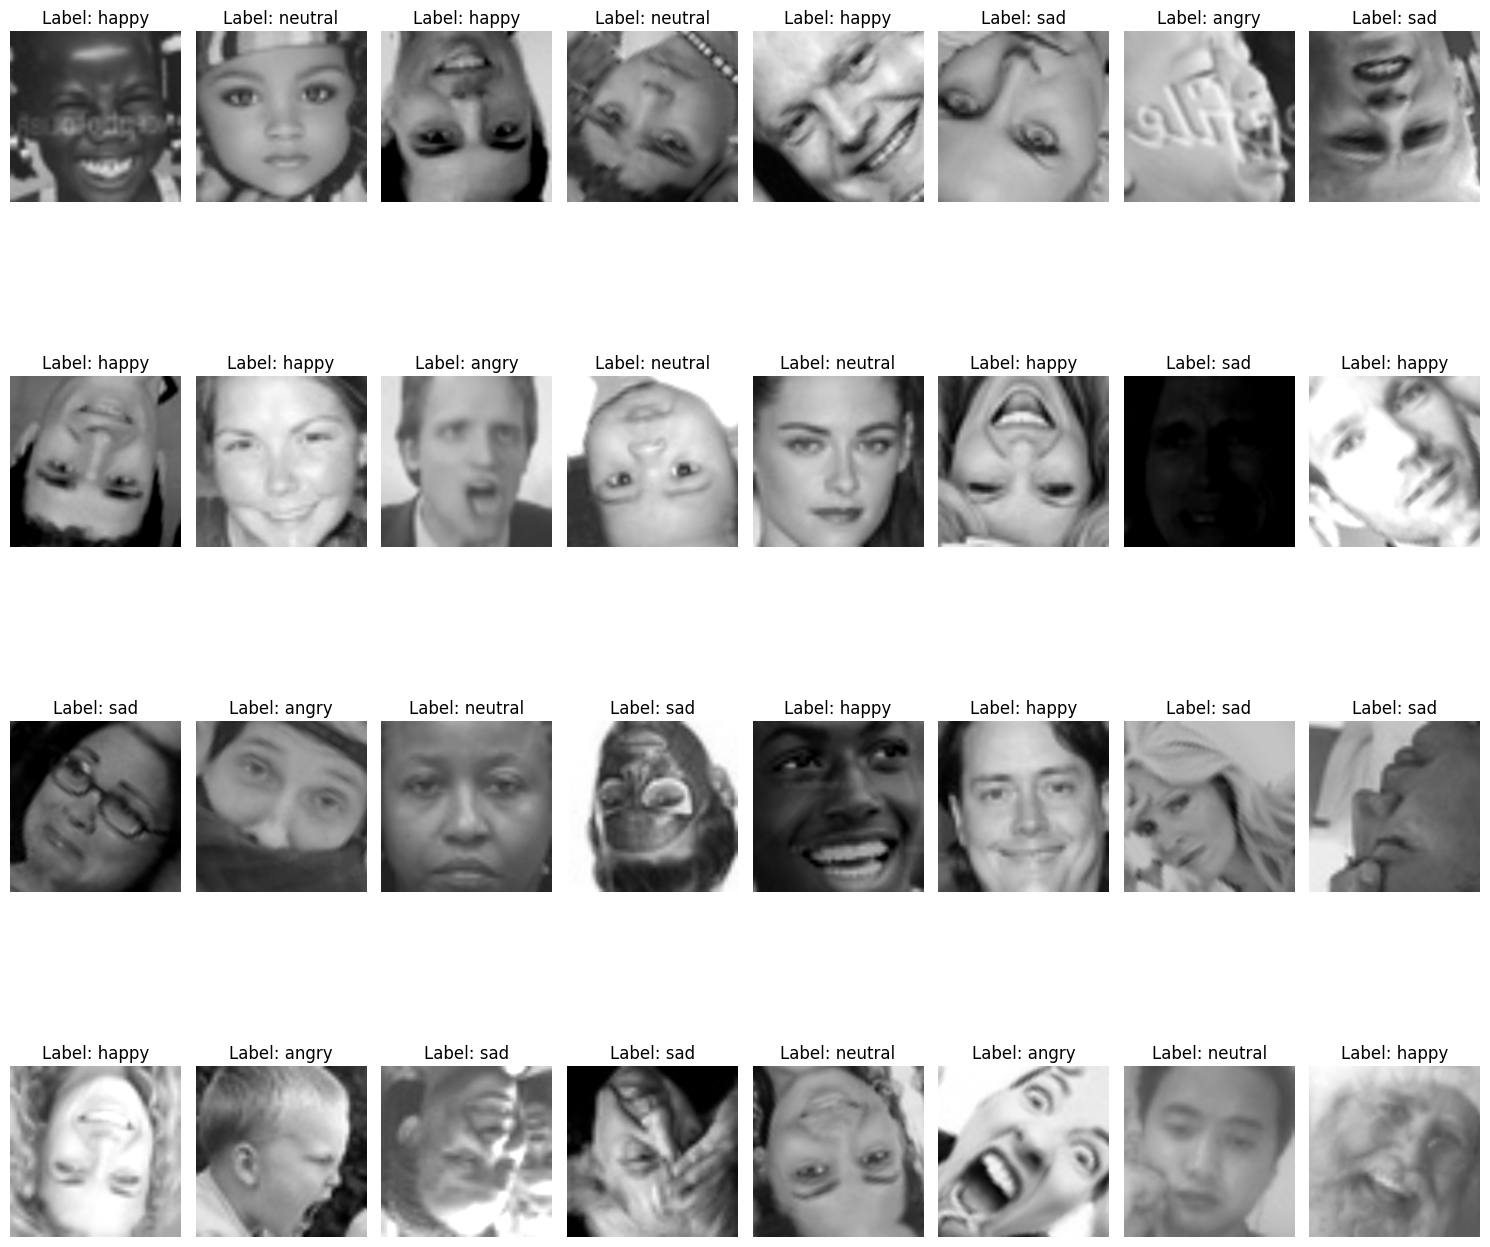

In [ ]:
import matplotlib.pyplot as plt

# Function to unnormalize images
def unnormalize_image(image, mean=0.5, std=0.5):
    return image * std + mean

# Function to display images in a batch with labels
def show_batch_images(images, labels, label_encoder):
    batch_size = images.size(0)
    plt.figure(figsize=(15, 15))

    for i in range(batch_size):
        # Unnormalize the image
        image = unnormalize_image(images[i].cpu()).numpy().squeeze()
        image = image.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)

        # If grayscale, squeeze the last dimension
        if image.shape[2] == 1:
            image = image.squeeze(-1)

        label = label_encoder.inverse_transform([labels[i].cpu().numpy()])[0]

        # Subplot for each image in the batch
        plt.subplot(4, 8, i + 1)
        plt.imshow(image, cmap="gray" if image.ndim == 2 else None)
        plt.title(f"Label: {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Fetch one batch and show images with labels
for images, labels in train_loader:
    show_batch_images(images, labels, train_dataset.label_encoder)
    break  # Display one batch only


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load the pretrained EfficientNet-B4 model
efficientnet_b4 = models.efficientnet_b4(pretrained=True)

# Freeze early layers (optional)
for param in efficientnet_b4.features.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match your classes
num_classes = 7  # Change this to your number of classes
efficientnet_b4.classifier[1] = nn.Linear(efficientnet_b4.classifier[1].in_features, num_classes)

# Print the model summary (optional)
print(efficientnet_b4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 183MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
import torch.optim as optim

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_b4 = efficientnet_b4.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = optim.Adam(efficientnet_b4.classifier[1].parameters(), lr=0.001)

# Optional learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Print device info (optional)
print(f"Using device: {device}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]
Validation Epoch 1: 100%|██████████| 132/132 [00:32<00:00,  4.10batch/s]


Epoch [1/5], Train Loss: 0.9788, Train Acc: 58.55%, Val Loss: 0.7960, Val Acc: 67.53%


Validation Epoch 2: 100%|██████████| 132/132 [00:31<00:00,  4.15batch/s]


Epoch [2/5], Train Loss: 0.7685, Train Acc: 68.97%, Val Loss: 0.7740, Val Acc: 68.17%


Validation Epoch 3: 100%|██████████| 132/132 [00:32<00:00,  4.11batch/s]


Epoch [3/5], Train Loss: 0.6939, Train Acc: 72.67%, Val Loss: 0.7464, Val Acc: 71.41%


Validation Epoch 4: 100%|██████████| 132/132 [00:31<00:00,  4.16batch/s]


Epoch [4/5], Train Loss: 0.6400, Train Acc: 75.07%, Val Loss: 0.6981, Val Acc: 71.79%


Validation Epoch 5: 100%|██████████| 132/132 [00:32<00:00,  4.11batch/s]


Epoch [5/5], Train Loss: 0.5994, Train Acc: 76.50%, Val Loss: 0.6714, Val Acc: 73.67%


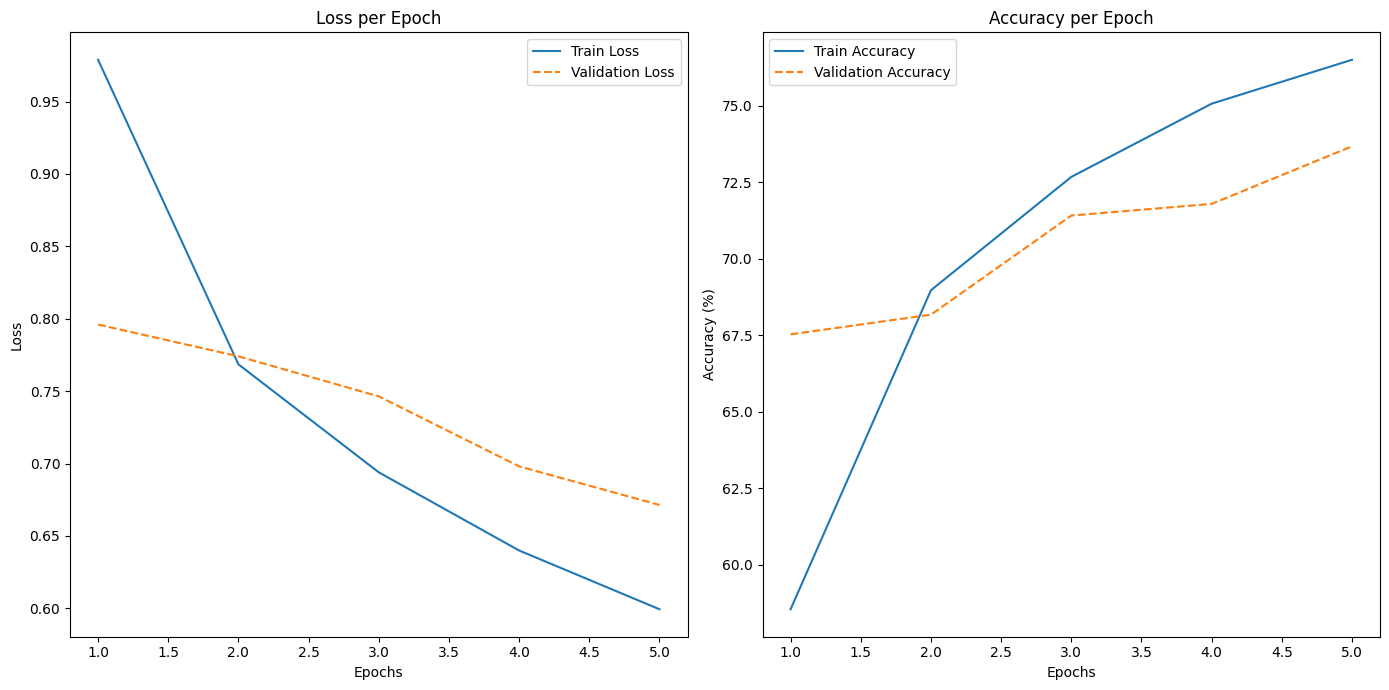

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # Import tqdm for progress bar

class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        # Load pre-trained EfficientNet-B4 and ResNet50 models
        self.efficientnet_b4 = models.efficientnet_b4(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)

        # Modify the output layers to match the number of classes in your dataset
        num_classes = 4

        # Replace the classification heads with new layers for both models
        self.efficientnet_b4.classifier[1] = nn.Linear(self.efficientnet_b4.classifier[1].in_features, num_classes)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through both models
        out_efficientnet = self.efficientnet_b4(x)
        out_resnet = self.resnet(x)

        # Average the outputs from the two models
        out = (out_efficientnet + out_resnet) / 2

        return out

# Initialize the ensemble model
ensemble_model = EnsembleModel().to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Training phase
    ensemble_model.train()
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = ensemble_model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track metrics
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            pbar.set_postfix(loss=running_train_loss / len(train_loader))
            pbar.update(1)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    ensemble_model.eval()
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    with tqdm(total=len(val_loader), desc=f'Validation Epoch {epoch+1}', unit='batch') as pbar:
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = ensemble_model(images)
                loss = criterion(outputs, labels)

                # Track metrics
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                pbar.update(1)

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Log epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Adjust the learning rate
    scheduler.step()

# Plot Loss and Accuracy Graphs
plt.figure(figsize=(14, 7))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# After the training loop, save the model
torch.save(ensemble_model, 'faceRecognition.pth')
print("Model saved successfully.")

In [ ]:
#!pip install transformers huggingface_hub

In [ ]:
#from huggingface_hub import notebook_login

#notebook_login()

In [ ]:
#from huggingface_hub import create_repo

#repo_id = "muhnatha/facecRecognition"
#create_repo(repo_id)

In [ ]:
#from huggingface_hub import upload_file

# Define the path to your saved model file
#model_path = "/content/faceRecognition.pth"

# Upload the model to your repository on Hugging Face
#repo_id = "muhnatha/facecRecognition"  # Replace with your repo ID

#upload_file(
   #path_or_fileobj=model_path,   # Path to your model.pth file
    #path_in_repo="model.pth",     # Destination name in the repo
    #repo_id=repo_id
#)
